## In this workshop, we will cover Hidden Markov Model and some examples of ensembles.    
Most of the materials are from the Machine Learning course at UoB.     
This workshop is presented by Zhiwei Wen.


### 1. HMM
We will look into Hidden Markov Models (HMM) to model sequential data. HMMs are widely used in speech recognition, natural language processing and bioinformatics. HMMs use Markov Chains to compute probabilities for a sequence of observed events. Moreover, HMMs are based on the Markov assumption, which states that the present state $z_n$ is sufficient to predict the future $z_{n+1}$, so the past $z_{0:n-1}$ can be discarded.

<img src="hmm.png" width="400">

If you are interested in the theory, there is short 9 min video here about HMM: https://www.youtube.com/watch?v=RWkHJnFj5rY    
If you are interested in Markov Chain as an important concept in Probability, please take MATH20008 Probability 2 (my favourite unit so far), or see this book:    
#### "J R Norris, Markov Chains, Cambridge University Press", available at UoB Queens Building Library and online.         
Often, we are in a situation where the states we are interested in are hidden, we cannot observe them directly. As we will see in examples below, the part-of-speech (POS) tags in a text are hidden and we can only observe the words. From these words we have to infer the tags. Similarly in Exercises 3 where a robot needs to be localised, we cannot observe the robot's position but rather the measurements of its sensors. Both the tags and the robot position are called hidden variables because they are not observed.
An HMM is specified by the following components:

* A set of $N$ states.

* A transition probability matrix $A$ where each element $a_{ij}$ represents the probability of moving from state $i$ to state $j$, s.t.  $ \sum^{N}_{j=1} a_{ij} = 1$ $ \forall i$

* An emission probability distribution, the probabilities of observations $x_n$ being generated from a state $z_n$

* An initial probability distribution over states. $\pi_n$ is the probability that the Markov chain will start in state $n$. Also, $\sum^{N}_{n=1} \pi_n = 1 $


### Additional packages

For this lab we need `hmmlearn`, `nltk`, `ipywidgets` which you can install with conda:

```python
conda install -c conda-forge hmmlearn
conda install -c anaconda nltk
conda install -c conda-forge ipywidgets
```

Let's import the libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from IPython import display

import nltk
from nltk.corpus import brown
from nltk.probability import ConditionalFreqDist,ConditionalProbDist,MLEProbDist
import itertools

from sklearn.model_selection import train_test_split


# interactive display
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'

### First example: HMM with 2 states
We will start with implementing an HMM with 2 states and then analyse how the transition probability and emission noise influence the output. Let's create a function `hmm_model` that has three arguments:
1. `switch_prob`: The probability of switching to the other state.
2. `noise_level`: The variance of the emission distribution, i.e. the measurement/observation noise.
3. `startprob`: The probabilities of starting in each state (`shape=(2,1)`).

The function should create a [hmm.GaussianHMM](https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.GaussianHMM) model with two states (hidden states) and `covariance_type="full"`. Modify the following model attributes:
* `startprob_`: Using the `startprob` argument.
* `transmat_`: Implement a transition matrix with probability of transition for both states being $p_{transition} = $ `switch_prob`.
* `means_`: Add mean $\mu_1 = 1$ and $\mu_2 = -1$ for each state
* `covars_`: Using the the `noise_level` argument. (note: the shape should be `(2, 1, 1)`, i.e. two $1\times1$ covariance matrices)

In [2]:
def hmm_model(switch_prob, noise_level, startprob):

    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = startprob
    # should be shape (2, 2), i.e., a transition matrix for 2 states
    model.transmat_ = np.array([[1. - switch_prob, switch_prob],
                                [switch_prob, 1. - switch_prob]])
    model.means_ = np.array([[1.0], [-1.0]])

    # should be shape (2, 1, 1), i.e., 2 1x1 covariance matrices
    model.covars_ = np.ones((2, 1, 1)) * noise_level
    
    return model

#Create an HMM with binary state variable and 1D Gaussian observations

Next, a function is needed to visualize the model:

In [3]:
def plot_hmm(model, states, observations):

#    Args:
#    model (hmmlearn model):               hmmlearn model used to get state means.
#    states (numpy array of floats):       Samples of the states.
#    observations (numpy array of floats): Samples of the states.

    nsteps = states.size
    fig, ax1 = plt.subplots(figsize=(8,4))
    states_forplot = list(map(lambda s: model.means_[s], states))
    ax1.step(np.arange(nstep), states_forplot, "--", where="mid", alpha=1.0, c="green")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Latent State", c="green")
    ax1.set_yticks([-1, 1])
    ax1.set_yticklabels(["State 1", "State 0"])

    ax2 = ax1.twinx()
    ax2.plot(np.arange(nstep), observations.flatten(), c="blue")
    ax2.set_ylabel("Observations", c="blue")
    ax1.set_ylim(ax2.get_ylim())
    plt.show(fig)

Next, execute the cell below to run your `hmm_model` and visualise the output with the provided `plot_hmm` function. 

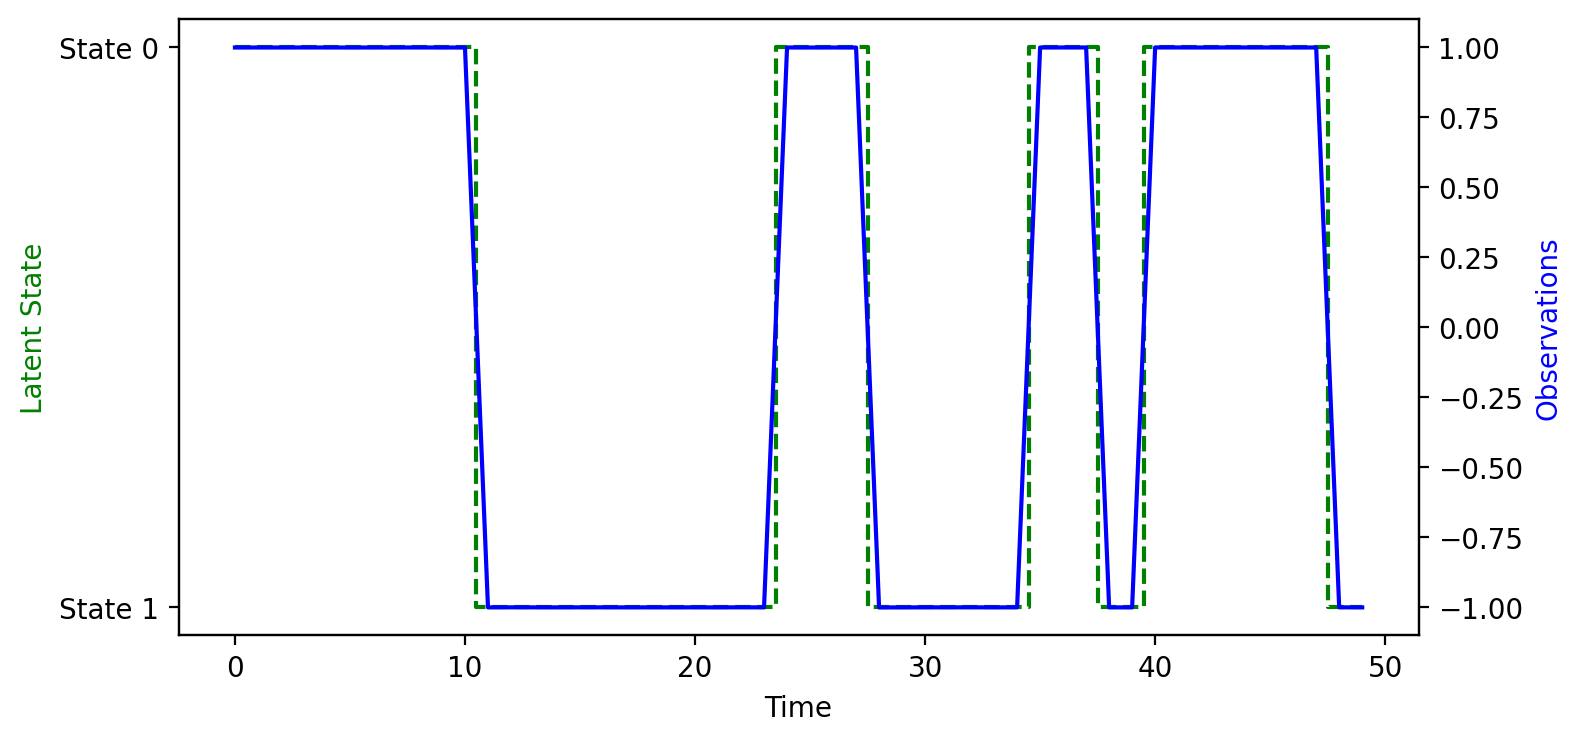

In [4]:
np.random.seed(101)
nstep = 50
model = hmm_model(switch_prob=0.1, noise_level=1e-8, startprob=np.array([1.0, 0.0]))
observations, states = model.sample(nstep)
plot_hmm(model, states, observations)

Run the cell below and experiment with the interactive widget window. Try changing the value of `switch_prob` and `noise_level`, how does that changes the output?

In [5]:
np.random.seed(101)
nstep = 50

@widgets.interact
def plot(switch_prob=(0., 1, .01), log10_noise_level=(-8., 1., .01)):
    model = hmm_model(switch_prob=switch_prob,
                    noise_level=10.**log10_noise_level,
                    startprob=[1.0, 0.0])

    observations, states = model.sample(nstep)
    observations = observations.flatten()
    plot_hmm(model, states, observations)

interactive(children=(FloatSlider(value=0.5, description='switch_prob', max=1.0, step=0.01), FloatSlider(value…

### Second Example: Part-of-speech (POS) tagging:    
Part-of-speech (POS) tagging enables the extraction of meaningful information about words in a sentence and their relation to neighbouring words. Knowing whether a word is a noun or a verb provides us information about their most likely neighboring words (such as nouns are preceded by determiners and adjectives, verbs by nouns) and syntactic structure (nouns are generally part of noun phrases), making POS tagging a key aspect of parsing. Parts of speech are useful features for labeling named entities like people or organisations in information extraction, or for coreference resolution. A word’s part of speech can even play a role in speech recognition or synthesis, e.g., the word content is pronounced CONtent when it is a noun and conTENT when it is an adjective.

Part-of-speech tagging is the process of assigning a POS tag to each word token in a given text. The input to a tagging algorithm is a sequence of tokenised words and the output is a sequence of tags, one per token. Particularly, words are ambiguous as they have more than one possible POS and the goal is to find the correct tag for each situation.
For example, "book" can be a verb ("book that flight") or a noun ("hand me that book"). The goal of POS-tagging is to resolve these ambiguities, choosing the proper tag for the context.


In this example we introduce the use of the Hidden Markov Model for part-of-speech tagging. The HMM can be used as a sequence tagger to assign a tag or class label to each unit in an observed sequence, thus mapping a sequence of observations to a sequence of labels. A HMM is a probabilistic sequence model: given a sequence of units (words, letters, morphemes, sentences), it computes a probability distribution over possible sequences of labels and chooses the best label sequence.

#### (1) Brown corpus dataset
The Brown corpus is a common dataset in Natural Language Processing (NLP), it is available from the NLTK library and it supports POS tagged information. Run the cell below to download the dataset and the universal tagset.

In [6]:
# download the Brown dataset
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/jerrywen188/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/jerrywen188/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

First we need to get the dataset and split it into training and testing.
Run the following cells to achieve that and to prepare the dataset in the correct format.

In [7]:
nltk_data = list(brown.tagged_sents(tagset='universal'))
train_set,test_set = train_test_split(nltk_data,
                                      train_size=0.80,
                                      test_size=0.20,
                                      random_state=101
                                      )

In [8]:
# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]
print(f'Number of tagged words in the training set: {len(train_tagged_words)}')
print(f'Number of tagged words in the test set: {len(test_tagged_words)}')

Number of tagged words in the training set: 927092
Number of tagged words in the test set: 234100


Let's explore the different types of tags by running the next cell.

In [9]:
tags = {tag for word, tag in train_tagged_words}
print(f'Number of possible tags: {len(tags)}')
print(f'Possible tags: {tags}')

Number of possible tags: 12
Possible tags: {'DET', 'PRON', 'ADV', 'VERB', 'ADJ', 'CONJ', '.', 'NOUN', 'X', 'NUM', 'ADP', 'PRT'}


The next cell, explores the structure of the dataset in terms of words and sentences.

In [10]:
print('Words example: {}'.format(train_tagged_words[0:5]))
print('Sentence example: {}'.format(train_set[0]))

Words example: [('A', 'DET'), ('Newfoundland', 'NOUN'), ('sat', 'VERB'), ('solemnly', 'ADV'), ('beside', 'ADP')]
Sentence example: [('A', 'DET'), ('Newfoundland', 'NOUN'), ('sat', 'VERB'), ('solemnly', 'ADV'), ('beside', 'ADP'), ('a', 'DET'), ('doghouse', 'NOUN'), ('half', 'PRT'), ('his', 'DET'), ('size', 'NOUN'), ('.', '.')]


### (2) POS tagging model

Two of the main components of HMMs are the transition model and the emission model. 

Specifically, the transition model $P(tag_{t+1}|tag_t)$ will estimate the probability of the next tag given the current tag while the emission model $P(word|tag_t)$ will estimate the probability of observing a word given the current tag.

Note: the provided hints link to the `ntlk.probability` functions, however you are free to use any other libraries such as `numpy`.

#### (2.1) Emission Model
Given the tagged words, the main steps are:
1. Create a list of tuples ($tag, word$) from the input `words` which will be utilised in step 2. (careful: `words` contains tuples of ($word, tag$))
2. Calculate the frequency for each word given the corresponding tag. (hint: [ConditionalFreqDist](https://www.nltk.org/api/nltk.html?highlight=conditionalfreqdist#nltk.probability.ConditionalFreqDist)) 
3. Calculate the conditional probability distribution given the frequency distribution of step 2. (hint: [ConditionalProbDist](https://www.nltk.org/api/nltk.html?highlight=conditionalprobdist#nltk.probability.ConditionalProbDist) with `probdist_factory`=`MLEProbDist`)

Next is to implement these steps in a function `emission_model` that has one argument, `words`, containing a list of `(word, tag)` pairs.

In [11]:
def emission_model(words):
    # calculate frequency of each word given tag
    # calculate conditional prob given the tag
    
    data = [(tag, word) for (word, tag) in words]
    emission_F = ConditionalFreqDist(data)
    emission_P = ConditionalProbDist(emission_F, probdist_factory=MLEProbDist)
    
    return emission_P

#### (2.2) Transition Model
Given the tagged sentences, the main steps are:
1. Create chain of tuples ($tag_{t}, tag_{t+1}$) to be passed to `ConditionalFreqDist()`. To achieve this efficiently:
    * Create a generator expression (similar to list comprehension but replacing `[]` with `()` which iterates over each sentence and for each sentence creates a pair of ($tag_{t}, tag_{t+1}$) (if you are curious about generator expressions, you can read [this](https://wiki.python.org/moin/Generators) and [this](https://realpython.com/introduction-to-python-generators/))
    * Create a chain from the ouput of the generator (hint: [itertools.chain.from_iterable()](https://docs.python.org/3.4/library/itertools.html#itertools.chain.from_iterable))
2. Calculate the frequency of the next tag given the previous tag. (hint: [ConditionalFreqDist](https://www.nltk.org/api/nltk.html))
3. Calculate the conditional probability distribution of the next tag given the previous tag. (hint: [ConditionalProbDist](https://www.nltk.org/api/nltk.html))

Next is to implement these steps in a function `transition_model` that has one argument, `sentences`, containing the dataset of sentences.

In [12]:
def transition_model(sentences):
    # iterate over each sentence
    # calculate the frequency of the next tag given the previous tag 
    # calculate the conditional probability distribution of the next tag given the previous tag
    
    tagGenerators=(((s[i][1],s[i+1][1]) for i in range(len(s)-1)) for s in sentences)
    data = itertools.chain.from_iterable(tagGenerators)
    
    transition_F = ConditionalFreqDist(data)
    transition_P = ConditionalProbDist(transition_F, MLEProbDist)
    
    return transition_P

Utilising the previously created models, the cell below trains the emission and transition models, the former using tagged words and the later on tagged sentences.

In [13]:
emission_p = emission_model(train_tagged_words)
transition_p = transition_model(train_set)

Based on the Brown corpus, the trained HMM gives the following probabilities:
* The probability of observing the world `city` given the tag `NOUN`.
* The probability of the tag `VERB` given the tag `NOUN`.

In [14]:
p_city_NOUN = emission_p['NOUN'].prob('city')
p_VERB_NOUN = transition_p['NOUN'].prob('VERB')
print('p(city|NOUN) = ', p_city_NOUN)
print('p(VERB|NOUN) = ', p_VERB_NOUN)

p(city|NOUN) =  0.0009174311926605505
p(VERB|NOUN) =  0.15875670429120206


#### Viterbi algorithm

The goal of the Viterbi algorithm is to find the most likely sequence of hidden states for a given sequence of observations. Specifically, we will utilise the Viterbi algorithm to find the tags of a sequence of untagged sentences, known as $decoding$. 
The benefit of this algorithm comes from its ability to efficiently determine the most probable path amongst the exponentially many possibilities. Doing so, it can reduce the complexity from $O(N^T)$ to $O(NT)$ where $N$ is the total number of words and $T$ is the total number of tags.    
Once the model is trained, algorithms like Viterbi are used to infer the most likely sequence of hidden states based on observed emissions.    
see this example: https://www.cis.upenn.edu/~cis2620/notes/Example-Viterbi-DNA.pdf

Below is a cell that implements the Viterbi algorithm. However, In most situations, the viterbi algorithm is provided in the machine learning library, e.g. GaussianHMM.predict: https://hmmlearn.readthedocs.io/en/latest/api.html .

In [15]:
def viterbi(observed_seq, states, start_p, transition_p, emit_p):
    eps = 0.00000001
    
    # Initialise the list, V, that will contain a dictionary for each element in the sequence. Each dictionary 
    # has the possible states (tags) as keys and its values are a dictionary with the keys:
    # 'prob': the probability of the sequence until this point
    # 'prev': the previous state used for backtracking.
    V = [dict()] 
    for state in states:
        # Compute the probability of each possible state for the first token in the sequence.
        V[0][state] = {"prob": start_p[state] * emit_p[state].prob(observed_seq[0]), "prev": None}

    # Run Viterbi for t > 0
    for t in range(1, len(observed_seq)):
        V.append({})
        for state in states:
            # In the forward pass, for each element of the observed_seq we want to store the maximum 
            # probability for the each state as well as the previous state. This probability is the product of
            # the maximum transition probability and the emission probability.
            
            # First we calculate the max_transition_prob by going through all the combinations between states.
            # The next line just initialises the max_transition_prob:
            max_transition_prob = -1

            for prev_state in states:
                # Next, we calculate each possible transition probability that results in tag_t = state.
                # The transition probability is given by the product between
                # the prob of the sequence until t-1 where tag_{t-1} = prev_state,
                # and the transition probability from prev_state to state.
                transition_prob = V[t - 1][prev_state]["prob"] * transition_p[prev_state].prob(state) #to-do
                
                #update the maximum transition_prob accordingly
                if transition_prob > max_transition_prob:
                    max_transition_prob = transition_prob
                    prev_state_selected = prev_state
                    
            # Calculate the max_prob given by the product of the maximum transition probability and the 
            # emission probability . Remember to add eps to each probability before multiplying them together
            max_prob = (max_transition_prob + eps) * (emit_p[state].prob(observed_seq[t]) + eps) #to-do
            
            V[t][state] = {"prob": max_prob, "prev": prev_state_selected}

    most_likely_seq = []
    max_prob = 0.0
    previous = None
    # Get most probable final state before backtracking
    for state, data in V[-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_state = state
    most_likely_seq.append(best_state)
    previous = best_state

    # Backtrack until the first observation
    for t in range(len(V) - 2, -1, -1):
        # add the most likely tag to the most_likely_seq. Remember: we are backtracking hence we need to 
        # add before the last tag (hint: most_likely_seq.insert() )
        most_likely_seq.insert(0, V[t + 1][previous]["prev"]) # to-do
        
        previous = V[t + 1][previous]["prev"]

    # print ('The steps of states are ' + ' '.join(most_likely_seq) + ' with highest probability of %s' % max_prob)

    return list(zip(observed_seq, most_likely_seq))

Run the cell below to get `n=10` random sentences as test data (untagged words).

In [16]:
import random, time
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)      #define a random seed to get same sentences when run multiple times

n = 10
# n = 11468 # whole test set
# choose random n numbers
rndom = [random.randint(1,len(test_set)) for x in range(n)]

# list of 10 sentences on which we test the model
test_run = [test_set[i] for i in rndom]
 
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
 
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

Run the cell below to use the Viterbi algorithm on the test set and check its POS tagging accuracy.

In [17]:
possible_tags = list(set([pair[1] for pair in train_tagged_words]))
start_pr = {}
for tag in possible_tags:
    start_pr[tag] = 1.0/len(possible_tags)
    
start = time.time()
predicted_tags = viterbi(test_tagged_words, possible_tags, start_pr, transition_p, emission_p)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy 
predicted_correct = [i for i, j in zip(predicted_tags, test_run_base) if i == j]  

accuracy = len(predicted_correct)/len(predicted_tags)
print('Prediction Accuracy: ', accuracy*100)

# accuracy ~= 97 for only 10 sentences (136 words)
# accuracy ~= 94.239 in 45 secs for all test data (234100 words)

Time taken in seconds:  0.007477998733520508
Prediction Accuracy:  97.05882352941177


Let's print the print the first 10 words and their predicted tags.

In [18]:
predicted_tags[0:10]

[('I', 'PRON'),
 ('forced', 'VERB'),
 ('confidence', 'NOUN'),
 ('into', 'ADP'),
 ('myself', 'PRON'),
 ('.', '.'),
 ('Falling', 'VERB'),
 ('somewhere', 'ADV'),
 ('in', 'ADP'),
 ('a', 'DET')]

as well as the mispredicted tags:

In [19]:
for i, j in zip(predicted_tags, test_run_base):
    if i != j:
        print(i,j)

('undeniably', 'VERB') ('undeniably', 'ADV')
('there', 'PRT') ('there', 'ADV')
('that', 'PRON') ('that', 'DET')
('wetly', 'NOUN') ('wetly', 'ADV')


### Third Example: Robot localisation

Another application of HMM application is robot localisation. 

We have a robot which is deployed to Mars to collect some samples. However, during the landing phase, the connection got temporarily lost and we are not sure where exactly the robot is. Luckily, the map of the area is available and the robot is provided with a sensor that can detect rocky surface.

The aim is to utilised HMM to localise the robot where the hidden variable $z$ is the position of the robot and the observation $x$ is given by the sensor measurement. 
The figure at the top of the notebook shows the relation between hidden variables $z$ with the observable variables $x$.  

We will achieve this through the discrete case of the Bayes Filter which consists of mainly two steps:
prediction step and measurement step.

First step:
$$ \overline{p}_{k,t} = \sum_i p(z_k | u_t, z_i) p_{i, t-1} $$
where:
* $\overline{p}_{k,t}$: the predicted belief of the new state $z_k$ at the current time $t$ based on the action (control $u_t$). 
* $p_{i, t-1}$: the belief of state $z_i$ at the previous time step $t_1$
* $p(z_k | u_t, z_i)$ : the transition probability of moving from state $z_i$ to state $z_k$ when taking action $u_t$.

In the second step, the knowledge from the measurement model $p(x_t | z_k)$ is combined with the predicted belief $\overline{p}_{k,t}$ to obtain the posterior belief $p_{i, t-1}$ of each state. This posterior belief becomes the current belief for the next time step.

$$ p_{i, t} = \eta p(x_t | z_k) \overline{p}_{k,t}  $$
$p(x_t | z_k)$ is also known as the likelihood, i.e. how likely it is to see an observation given the robot is in location $z_k$. We need to get the likelihood before implementing the belief. Moreover $\eta$ is the normalising term such that the probability adds to 1.

Implementation of both World and Robot class:

In [20]:
class World():
    def __init__(self,start=(0,0),N=15):
        self.world = np.zeros((N,N))
        self.world[0,:] = 1
        self.world[-1,:] = 1
        self.world[:,0] = 1
        self.world[:,-1] = 1
        self.world[5, 6:12] = 1
        self.world[6:11, 9] = 1
        self.world[7:10, 6] = 1
        self.world[11, 4:10] = 1
        self.N = N
    
    def get_world(self):
        return self.world
    def set_world(self,N):
        self.world = np.zeros((N,N))
    def show_world(self):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
        ax.set_xticks(np.arange(-.5, self.N, 1));
        ax.set_yticks(np.arange(-.5, self.N, 1));
#         ax.axis('off')
        im = ax.imshow(self.world)
        plt.colorbar(im)
        plt.show()    

The robot has 4 possible actions: up, down, left and right. Each action will transition the robot in the new state with probability `p_move`. At each state the robot can measure whether the surface is rocky or normal by calling `measurement()` with the sensor's noise value of `p_sense`.

In [21]:
class Robot:
    def __init__(self, p_move, p_sense, world):
        self.location = np.random.randint(0,world.shape[0],2)
        self.p_move = p_move
        self.p_sense = p_sense
        self.world =  world
        self.N = self.world.shape[0]
        self.possibleActions = ['U', 'D', 'L', 'R']
        self.tracking_error = []
        self.homing_error = []

    # The robot transition are noisy with prob_move to follow the action and (1-p_move) of staying
    # in the same location
    def transition(self,action):
        if (np.random.rand() < self.p_move):
            if(action == 'U' ):
                self.location =  (max(0,self.location[0]-1), self.location[1])
            elif(action == 'R'):
                self.location = (self.location[0], min(self.N-1,self.location[1]+1))
            elif(action == 'D'):
                self.location = (min(self.N-1,self.location[0]+1), self.location[1])
            elif(action == 'L'):
                self.location = (self.location[0], max(0,self.location[1]-1))
            
        return self.location

    # Measurement model which returns 1 when the surface is rocky and 0 otherwise.
    # As in transition model, the sensor can be noisy with p_sense of returning the correct value.
    def measurement(self):
        if (np.random.rand() < self.p_sense):
            return self.world[int(self.location[0]),int(self.location[1])]
        else:
            if self.world[int(self.location[0]),int(self.location[1])] == 0:
                return 1
            else:
                return 0

    # transition model of the robot assuming no noise
    def transition_no_noise(self,location,action):
        if(action == 'U' ):
            location =  (max(0,location[0]-1), location[1])
        elif(action == 'R'):
            location = (location[0], min(self.N-1,location[1]+1))
        elif(action == 'D'):
            location = (min(self.N-1,location[0]+1), location[1])
        elif(action == 'L'):
            location = (location[0], max(0,location[1]-1))
            
        return location

    def visualise_true_position(self):
        x = self.world.copy()
        x[int(self.location[0]),int(self.location[1])] = 0.5
#         x[int(self.home[0]),int(self.home[1])] = 0.7

        return x

The map is discrete and represented through grids where each grid indicates a position. 
As displayed below, the yellow corresponds to the rocky surface while the purple corresponds to the normal surface. The sensor measurement will output a value of 1 for the rocky surface and a value of 0 for the normal surface.

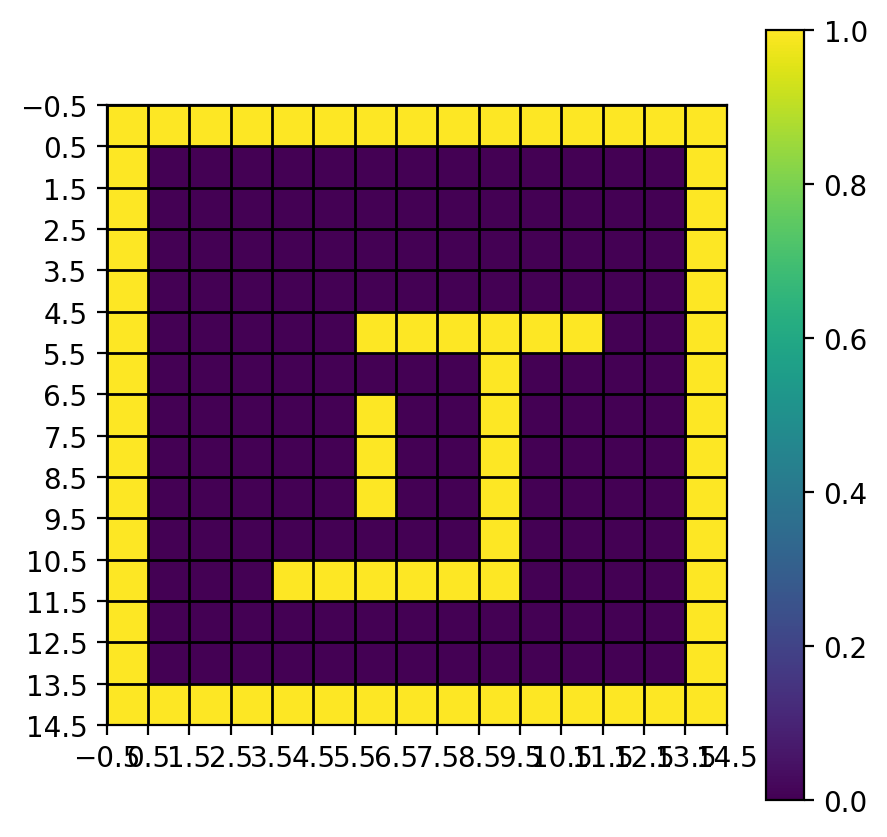

In [22]:
world = World(15)
world.show_world()

Run the following two cells to initialise the robot class and show the starting position.

In [23]:
p_move = .9  # original value 0.9
p_sense = .8 # original value 0.8
N = 15
# Initialise belief in position - uniform distribution over world
state_belief = np.ones((N,N))/(N*N)

robot = Robot(p_move,p_sense,world.get_world())

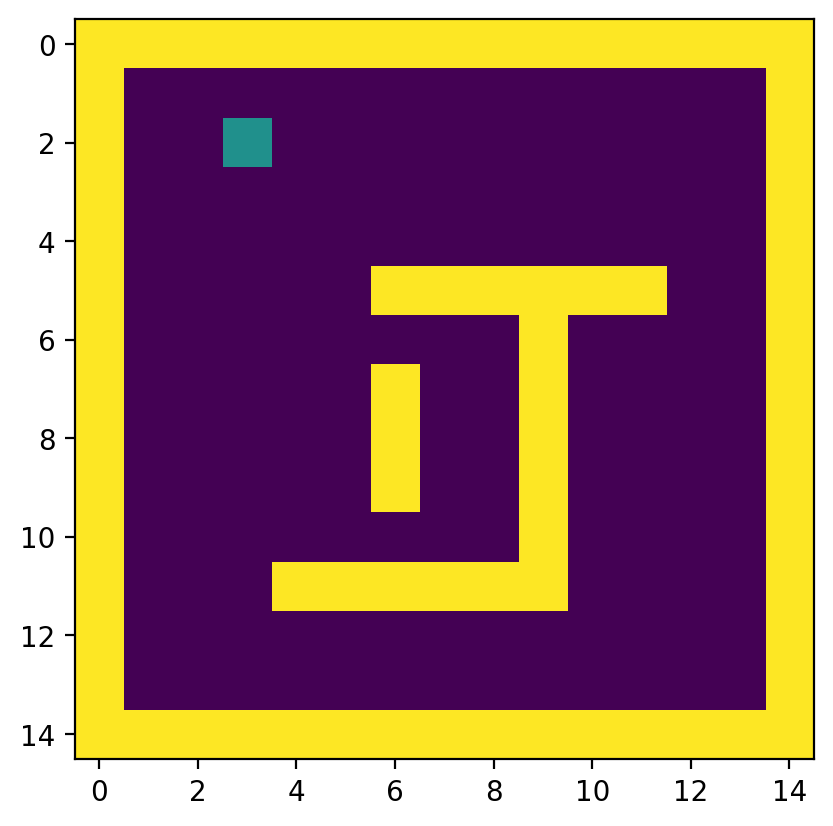

In [24]:
plt.imshow(robot.visualise_true_position());

The next cell provides helper functions to visualise the true robot position, the predicted belief, the likelihood and the posterior belief.

In [25]:
def show(robot, predicted_state_belief, likelihood, state_belief):
    plt.clf()
    plt.subplot(2,4,1)
    plt.cla()
    plt.imshow(robot.visualise_true_position())
    plt.title('True position in world')
    
    plt.subplot(2,4,2)
    plt.cla()
    plt.imshow(predicted_state_belief)
    plt.title('Predicted belief given action')
    
    plt.subplot(2,4,3)
    plt.cla()
    plt.imshow(likelihood)
    plt.title('Likelihood')
    
    plt.subplot(2,4,4)
    plt.cla()
    plt.imshow(state_belief)
    plt.title('Posterior belief given measurement')

The next cell contains the main algorithm.

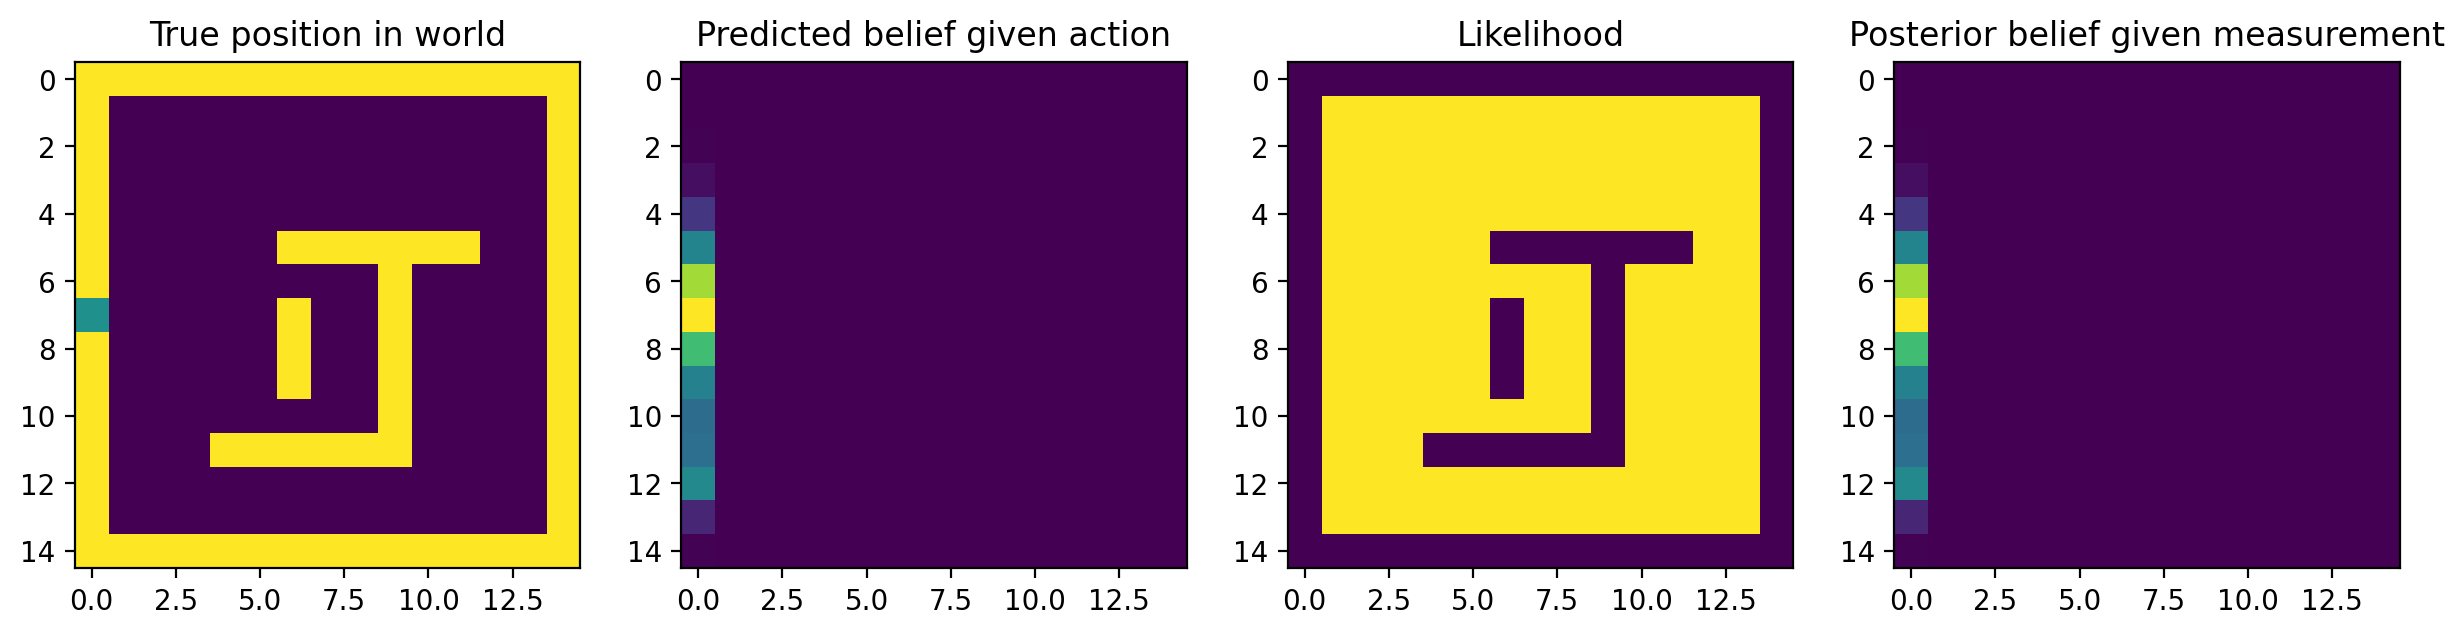

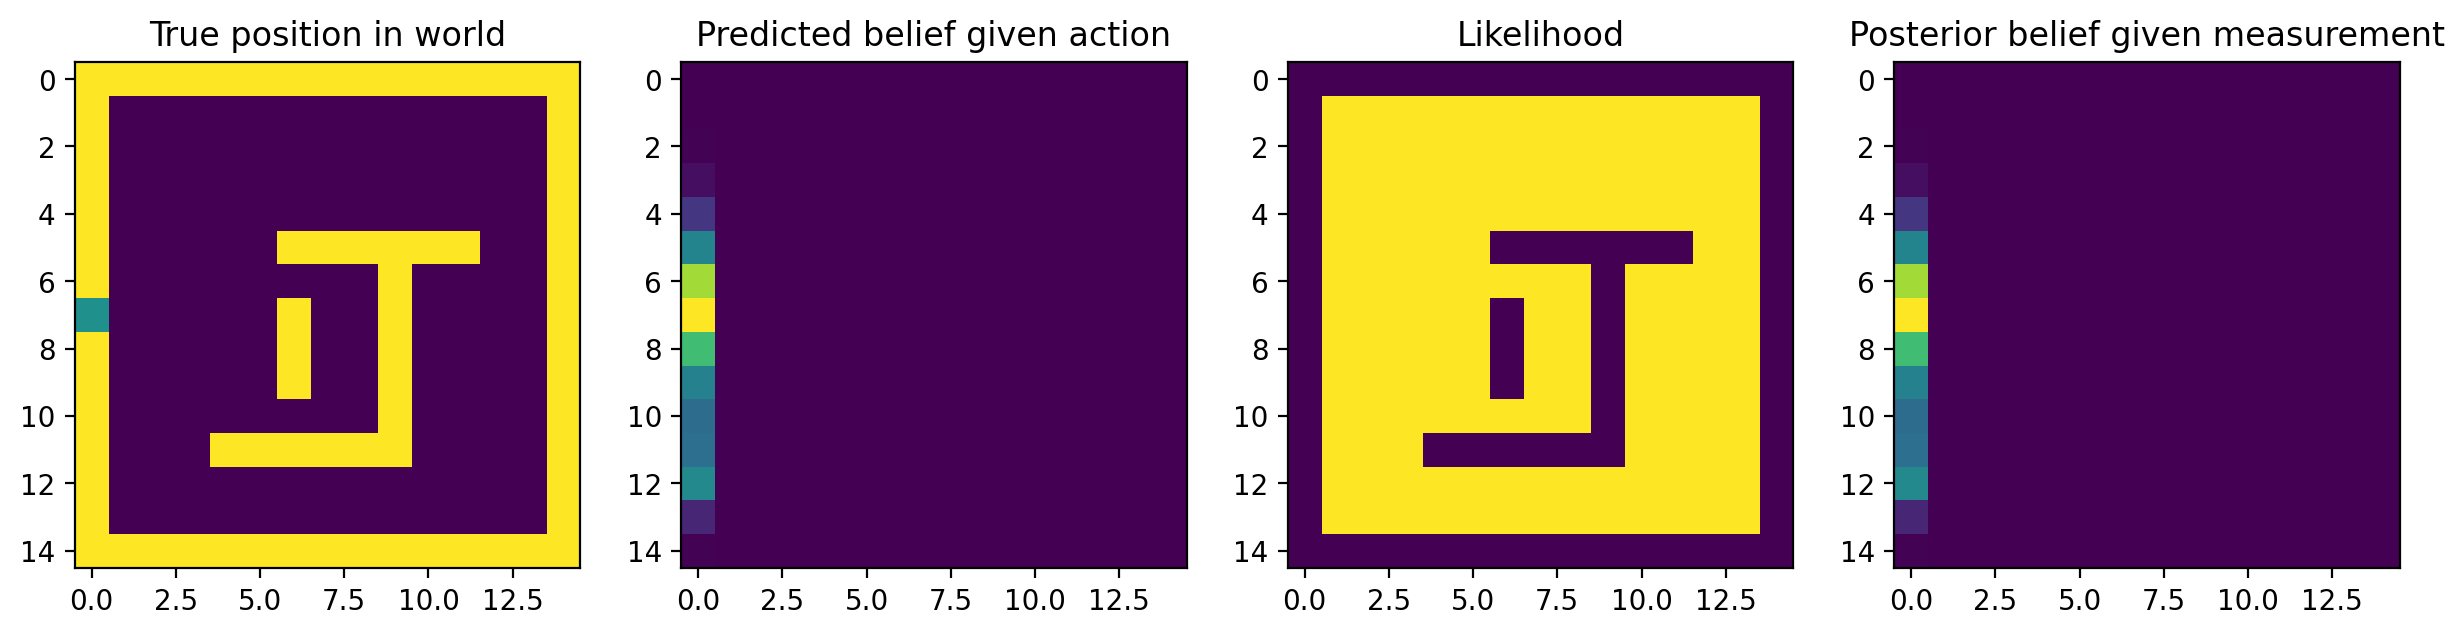

In [26]:
# Run the discrete Bayes filter
plt.figure(figsize=(15,9))

N = 15
steps = 100
# Create list of possible states in world (x,y coordinates)
possible_states = np.array(np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,N-1,N))).reshape(2,-1).T

for step in range(steps):
    
    # Sample a random action
    a = np.random.choice(['U','D','L','R'])
    
    # Move the robot according to the action and sense the measurement
    state = robot.transition(a)
    measurement = robot.measurement()
    
    # Make prediction about state belief given action
    predicted_state_belief = np.zeros((N,N))
    
    for state in possible_states.astype(int):
        
        new_state = robot.transition_no_noise(state,a)
        
        predicted_state_belief[state[0],state[1]] += (1-p_move)*state_belief[state[0],state[1]] 
        predicted_state_belief[new_state[0],new_state[1]] += p_move*state_belief[state[0],state[1]] 
   
    # Evaluate sensor belief for each possible state
    likelihood = np.zeros((N,N))
    for state in possible_states.astype(int):
        
        match = measurement == world.get_world()[state[0],state[1]]
        likelihood[state[0],state[1]] = match*p_sense + (1-match)*(1-p_sense) 
    
    # Compute posterior belief over possible states
    state_belief = likelihood*predicted_state_belief # to-do
    
    # normalising
    state_belief = (state_belief+1e-15)
    state_belief = state_belief/np.sum(state_belief) 
    
    # Make a function to display
    show(robot, predicted_state_belief, likelihood, state_belief)

    display.clear_output(wait=True)
    display.display(plt.gcf())

### Forth Example: Activity recognition dataset sequential labelling

Here, we will use the sequence labelling data in the notebook to label each sequence of observations, taking their order into account, for the activity_recognition dataset.    
we will be working with the dataset “Activity recognition with healthy older people using a batteryless wearable sensor”. This dataset contains sequences of readings taken from several sensors on a device worn by a person as they move about in a room. The goal is to predict the activity label for each data point, i.e., what the person was doing, which may be:    
1: sit on bed     
2: sit on chair     
3: lying or     
4: ambulating    
https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor

Firstly, we load the data: 

In [27]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")


The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [28]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size

The cell below achieve the train-test split:

In [29]:
from sklearn.model_selection import train_test_split
# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  
# You may wish to make further splits of the data or to modify this split.
print(X_by_seq_tr)

[array([[ 1.0787e-01,  9.0487e-01, -8.2102e-02, -4.4500e+01,  4.6250e+00,
         9.2225e+02],
       [ 2.0168e-01,  1.0427e+00, -2.5087e-02, -4.5000e+01,  3.5358e+00,
         9.2575e+02],
       [ 2.4858e-01,  1.1690e+00, -7.0699e-02, -6.5500e+01,  5.2140e+00,
         9.2575e+02],
       [ 2.4858e-01,  1.1690e+00, -7.0699e-02, -5.6500e+01,  5.5837e+00,
         9.2425e+02],
       [ 2.4858e-01,  1.1690e+00, -7.0699e-02, -5.0500e+01,  6.2433e-01,
         9.2475e+02],
       [ 2.8376e-01,  1.0886e+00,  2.0525e-02, -5.6500e+01,  1.5309e+00,
         9.2075e+02],
       [ 7.2698e-02,  7.6708e-01,  7.7541e-02, -5.7500e+01,  1.3116e+00,
         9.2575e+02],
       [ 7.2698e-02,  7.6708e-01,  7.7541e-02, -5.6500e+01,  1.7012e+00,
         9.2375e+02],
       [ 6.3552e-01,  7.4411e-01,  2.7139e-01, -5.1500e+01,  8.1454e-01,
         9.2525e+02],
       [ 7.0587e-01,  7.6708e-01,  4.3332e-02, -5.5000e+01,  5.3459e+00,
         9.2275e+02],
       [ 7.0587e-01,  7.5559e-01,  4.3332e-02, -5

In [30]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label
for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])
#This is for calculating transition probability and initial probability

Now lets train the model: (I recommand you try it before reading the following cell for an example answer)Hint: this is a supervised learning example.

In [31]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM
import numpy as np
from collections import Counter
# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))
# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)
# Count how often each state appears as an initial state
initial_state_counts = Counter(seq[0] for seq in y_by_seq_tr)

# Total number of sequences
total_sequences = len(y_by_seq_tr)

# Calculate initial state probabilities
initial_state_probabilities = np.array([initial_state_counts[state] / total_sequences for state in range(n_states)])
# Initialize transition counts
transition_counts = np.zeros((n_states, n_states))

# Count transitions
for seq in y_by_seq_tr:
    for (from_state, to_state) in zip(seq[:-1], seq[1:]):
        transition_counts[from_state, to_state] += 1

# Normalize to get transition probabilities
transition_probabilities = transition_counts / transition_counts.sum(axis=1, keepdims=True)
# Initialize a Gaussian HMM
n_states = 4
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag",algorithm='viterbi')
model.means_ = np.array(means)
model.covars_ = np.array(diagonal_covars)
model.startprob_ = initial_state_probabilities
model.transmat_ = transition_probabilities


Now lets test the hmmmodel:

In [32]:
from sklearn.metrics import accuracy_score

total_correct = 0
total_labels = 0

for X_test, y_test in zip(X_by_seq_test, y_by_seq_test):
    # Flatten y_test because it's a sequence of arrays
    y_test = np.concatenate(y_test) if isinstance(y_test[0], np.ndarray) else y_test

    # Predict the state sequence for the current test sequence
    predicted_states = model.predict(X_test)

    # Calculate accuracy for this sequence
    sequence_accuracy = accuracy_score(y_test, predicted_states)

    # Update total correct predictions and label count
    total_correct += np.sum(predicted_states == y_test)
    total_labels += len(y_test)

# Overall accuracy
overall_accuracy = total_correct / total_labels
print("Overall accuracy on test:", overall_accuracy)
total_correct = 0
total_labels = 0
for X_test, y_test in zip(X_by_seq_tr, y_by_seq_tr):
    # Flatten y_test because it's a sequence of arrays
    y_test = np.concatenate(y_test) if isinstance(y_test[0], np.ndarray) else y_test

    # Predict the state sequence for the current test sequence
    predicted_states = model.predict(X_test)

    # Calculate accuracy for this sequence
    sequence_accuracy = accuracy_score(y_test, predicted_states)

    # Update total correct predictions and label count
    total_correct += np.sum(predicted_states == y_test)
    total_labels += len(y_test)
overall_accuracy = total_correct / total_labels
print("Overall accuracy on training set:", overall_accuracy)


Overall accuracy on test: 0.8418582824964805
Overall accuracy on training set: 0.905161752261928


Let's have a look at the transition matrix:

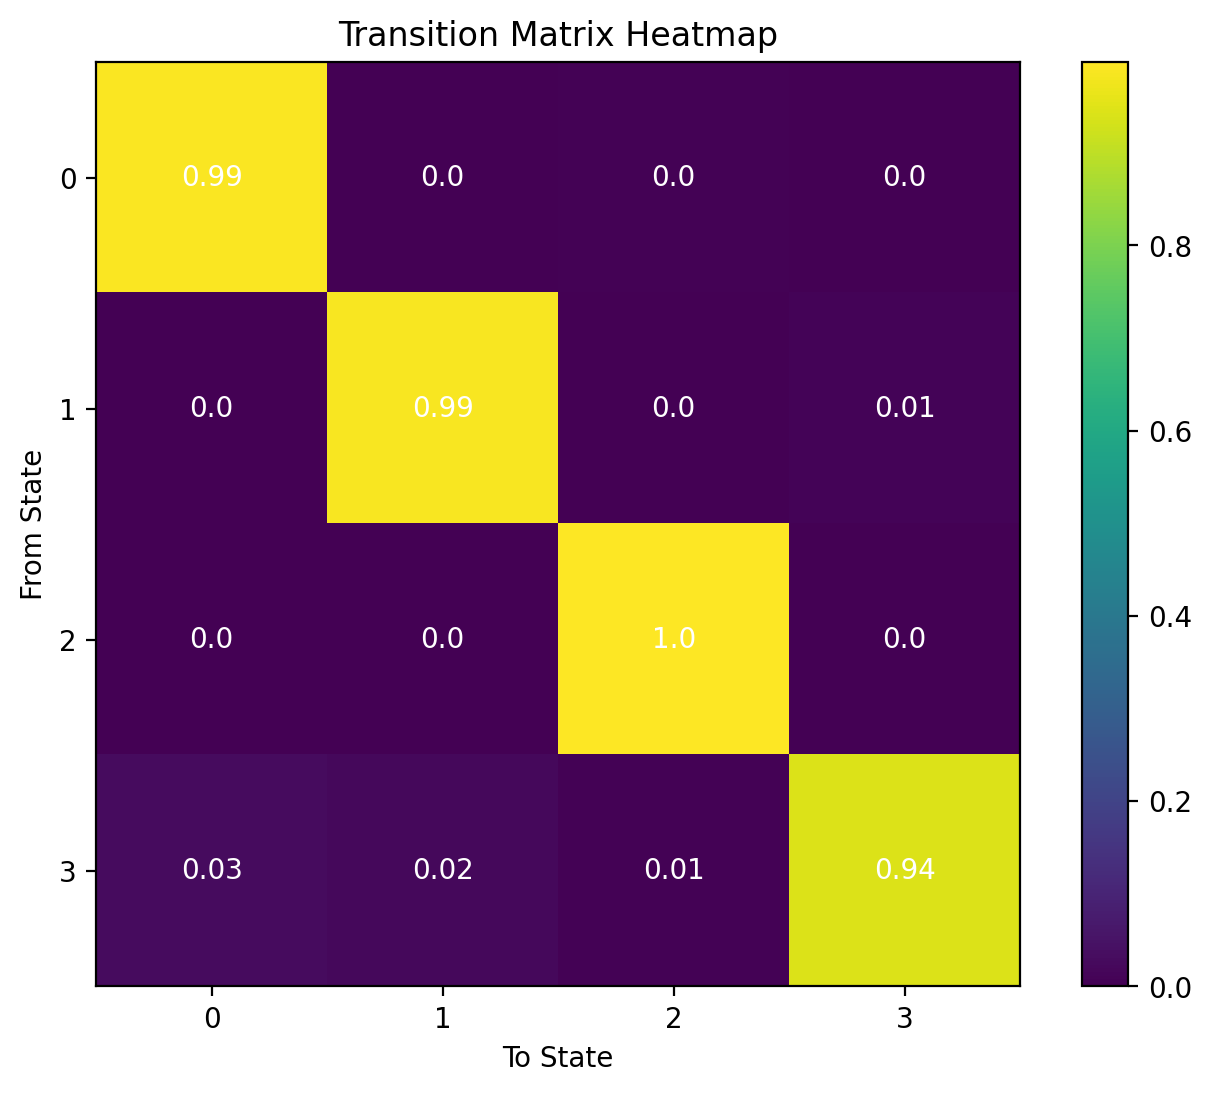

In [33]:
import matplotlib.pyplot as plt
transition_matrix = model.transmat_
# Plotting the transition matrix
plt.figure(figsize=(8, 6))  
cmap = plt.cm.viridis  # A colormap with better contrast for low values
heatmap = plt.imshow(transition_matrix, cmap=cmap, interpolation='nearest')
plt.colorbar(heatmap)

# Adding labels for clarity
states = range(transition_matrix.shape[0])
plt.xticks(states)
plt.yticks(states)
plt.xlabel('To State')
plt.ylabel('From State')
plt.title('Transition Matrix Heatmap')

# Annotate each cell with the numeric value
for i in range(transition_matrix.shape[0]):
    for j in range(transition_matrix.shape[1]):
        text = plt.text(j, i, np.round(transition_matrix[i, j], 2),
                        ha="center", va="center", color="w")

plt.show()

### 2. Ensemble Methods examples

We will look at how collections of decision trees (or other machine learning models) can be trained on the same dataset and combined to enhance predictive performance. Specifically, we will look at bagging, random forests and boosting which are all related examples of ensemble methods.

Before starting, make sure to install the `graphviz` package using `conda install python-graphviz`.     
First, let's import necessary kits:

In [34]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import graphviz

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/jerrywen188/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['text', 'random', 'display', 'show', 'plot', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### 1) Bagging
The combination of models can often perform much better than the average individual, and sometimes better than the best individual. Ensemble methods are ways of combining multiple models together. For good performance, the models should be diverse to minimise the expected error of the ensemble.

Bagging 'bootstrap aggregation' is a simple ensemble method that induces diversity by training M models on different samples of the training set (with replacement) and combining predictions by taking the mean or majority vote. An approximate bagging algorithm is:
1. For $m = 1,...,M$ models:
    - Randomly sample N data points with replacement from the training set
    - Learn a decision tree (CART algorithm) on the subset
2. The final prediction is found by a majority vote

Let's load the data first:

In [35]:
# load the MNIST data
X_mnist, y_mnist = fetch_openml(name='mnist_784',return_X_y=True, as_frame=False,parser='auto')
random.seed(5)
frac_of_dataset = 0.5
index = int(frac_of_dataset*X_mnist.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X_mnist[:index,:], y_mnist[:index], test_size=0.2)

Now let's train a bagging ensemble of decision trees

In [36]:
num_models = 20
sample_size = 2000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_train.shape[0], sample_size)
    X_train_sample, y_train_sample = X_train[sample_idx], y_train[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)

Next, Implement bagging prediction: the `bagging_predict` function create predictions from the bagging ensemble based on majority voting of the individual models. 

In [37]:
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(int64(votes[test_point])).argmax()
    
    return combined_predictions

In [38]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.8985714285714286


Compare the performance with the single decision tree:

In [39]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print("Training set accuracy: {}".format(model.score(X_train, y_train)))
print("Test set accuracy: {}".format(model.score(X_test, y_test)))

Training set accuracy: 1.0
Test set accuracy: 0.8467142857142858


Feel free to adjust the `sample_size` and `num_models` hyperparameters and see the effects.

#### 2) Random Forests
With bagging, the base models (individual decision trees) make similar splits on the same features, meaning that their errors are correlated and this reduces the diversity of the ensemble and limits performance.

Random forests improve the diversity of the base models by limiting the number of features considered for determining each split in the decision tree. We can obtain the random forest by modifying the bagging algorithm above so that each split for each model uses only a random subset of features.

In [40]:
num_models = 20
sample_size = 2000  # training set size.
feature_sample_size = 200
np.random.seed(0)

all_models = []
all_selected_features = []  # for each model, save the list of selected feature indexes.
for m in range(num_models):
    # copy in the code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    sample_idx = np.random.choice(X_train.shape[0], sample_size)
    X_train_sample, y_train_sample = X_train[sample_idx], y_train[sample_idx]

    # create a decision tree classifier with limited features considered
    # for each split
    model = DecisionTreeClassifier(max_features=feature_sample_size)
    
    # copy in the code from the bagging exercise here to train a decision tree classifier on the random sample.
    # Remember to train it only on the random sample of features.
    model.fit(X_train_sample, y_train_sample)
    
    all_models.append(model)

Use the `bagging_predict` function from above to generate predictions for the random forest and calculate the accuracy.

In [41]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.9134285714285715


#### 3)Boosting    
We can use a decision tree classifier as the base model for the ensemble method known as boosting. Boosting involves training base models in sequence to ensure that each base model addresses the weaknesses of the ensemble. Instead of training a new base model on a random sample, we weight the data points in the training set according to the performance of previous base models.

AdaBoost (adaptive boosting) is a popular boosting method, where training examples that are misclassified by one of the base classifiers are given greater weight when used to train the next classifier in the sequence. Once all the classifiers have been trained, their predictions are then combined through a weighted majority voting scheme.

The AdaBoost algorithm description is given below:
1. Initialize the data weighting coefficients $w_n$ by setting $w_n^{(1)} = 1/N$ for $ n = 1,...,N$ where $N$ is the number of training examples
2. For $m = 1,...,M$ models:
    - Fit a classifier $y_m(x)$ to a subset of the training data by minimising the weighted error function (hint: specify the `sample_weight` when fitting the model using scikit-learn).
    - Calculate the weighted error, $\epsilon_m$, where
    - $$\epsilon_m = 1 - \text{weighted accuracy} = 1 - \frac{\sum_{n=1}^{N}{w_nI(y_m(x_n) = t_n)}}{\sum_{n=1}^{N}{w_n}}$$

    and $I$ is the indicator function that equals $1$ when the condition is true (hint: the computation for the weighted accuracy is done for you if `sample_weight` is specified when calling the [`score`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score) function).
    - Calculate the model weighting coefficients, $\alpha_m$, where
    $$\alpha_m = ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$$
    - Update the data weighting coefficients
    $$w_n^{(m+1)} = w_n^{(m)} exp(\alpha_m \space I(y_m(x_n) \neq t_n))$$ where, again, $I$ is the indicator function.
3. The final prediction is a weighted combination of the trained base classifiers weighted by $\alpha_m$.

#### Train an ensemble of models using Adaboost algorithm:

In [42]:
num_models = 200 # number of base classifiers
sample_size = 2000  # sample training set size.
np.random.seed(0)

# initialise the sample weights for all data points in the training set.
sample_weights = np.ones(X_train.shape[0])/X_train.shape[0]

alphas = []
all_models = []
for m in range(num_models):
    # copy in the code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    sample_idx = np.random.choice(X_train.shape[0], sample_size)
    X_train_sample, y_train_sample = X_train[sample_idx], y_train[sample_idx]

    model = DecisionTreeClassifier(max_depth=10)
    # train a decision tree classifier on the weighted random sample.
    # Hint: fit() takes an additional argument, 'sample_weights'.
    model.fit(X_train_sample, y_train_sample, sample_weights[sample_idx])
    
    # compute the model error using weighted accuracy for the sampled training dataset
    # Hint: score() score takes an additional argument, 'sample_weight'.
    error = 1-model.score(X_train_sample, y_train_sample, sample_weights[sample_idx])
    
    # calculate alpha for the model and append alpha to alphas
    alpha = log((1-error)/error)
    alphas.append(alpha)

    # update the sample_weights for incorrect predictions using alpha
    incorrect_preds = model.predict(X_train_sample) != y_train_sample
    sample_weights[sample_idx] *= exp(alpha*incorrect_preds)
    
    all_models.append(model)

Below is the `boosting_predict` function to produce predictions from the trained models. In addition to the test data and the trained models, the function also takes the list of $\alpha_m$ as an input which determines the weighting of each individual model on the overall output.

In [43]:
def boosting_predict(test_data, all_models, alphas):
    votes = np.zeros((test_data.shape[0], len(all_models))) 
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # write your code here to obtain the predictions from model m and store it in votes.
        votes[:, idx] = m.predict(test_data)  
        
    
    for test_point in range(len(votes)):
        # determine the class with the most votes for each test point and store it in combined_predictions
        # hint: remember the weighting alpha
        combined_predictions[test_point] = np.bincount(int64(votes[test_point]), alphas).argmax()
    
    return combined_predictions

In [44]:
prediction = boosting_predict(X_test, all_models, alphas)
accuracy = np.count_nonzero(prediction==int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.9382857142857143


Try out different values of `sample_size`, `num_models` and `max_depth` of the decision tree. Notice the performance compare with other methods and the training time.

Luckily, scikit-learn can help us avoid defining all the models and their prediction function by ourselves.    

Back to the     
##### activity recognition dataset    
and See the example below:

In [45]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [46]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [48]:
#Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=20)
rf_classifier.fit(X_tr, y_tr) 
print("Training set accuracy: {}".format(rf_classifier.score(X_tr, y_tr)))
print("Test set accuracy: {}".format(rf_classifier.score(X_test, y_test)))

Training set accuracy: 0.9999349085465078
Test set accuracy: 0.8412325981542312


In [49]:
#Gradient Boosting
gb_classifier = GradientBoostingClassifier(n_estimators=100,random_state=20)
gb_classifier.fit(X_tr, y_tr) 
print("Training set accuracy: {}".format(gb_classifier.score(X_tr, y_tr)))
print("Test set accuracy: {}".format(gb_classifier.score(X_test, y_test)))

Training set accuracy: 0.9569528520905205
Test set accuracy: 0.8427968090098545


In [50]:
#AdaBoost Classifier
ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),n_estimators=100, random_state=20)
ada_clf.fit(X_tr, y_tr)
print("Training set accuracy: {}".format(ada_clf.score(X_tr, y_tr)))
print("Test set accuracy: {}".format(ada_clf.score(X_test, y_test)))

Training set accuracy: 0.9998698170930157
Test set accuracy: 0.8393555451274832


For hyperparameter tuning, see official document:     
For example, Adaboosting: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html